# Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings('ignore')  # Suppress warnings

# Optional: Import statsmodels for seasonal decomposition
try:
    from statsmodels.tsa.seasonal import seasonal_decompose
    from statsmodels.tsa.stattools import adfuller
    statsmodels_available = True
except ImportError:
    statsmodels_available = False
    print("Statsmodels not available, seasonal analysis will be limited")

# Set Matplotlib and Seaborn styles for better visualization
plt.style.use('ggplot')
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

# Load data

In [2]:
df = pd.read_csv('vendor_aging.csv')

# Prepare data for time series analysis (from previous notebooks)
def prepare_time_series_data(df, snapshot_date_col='Snapshot_Date', vendor_id_col='Vendor ID'):
    """
    Prepare vendor aging data for time series analysis by handling snapshot dates.
    """
    # Create a copy to avoid modifying the original
    result_df = df.copy()

    # Convert snapshot date to datetime if it's not already
    if not pd.api.types.is_datetime64_any_dtype(result_df[snapshot_date_col]):
        result_df[snapshot_date_col] = pd.to_datetime(result_df[snapshot_date_col], errors='coerce')

    # Convert last payment date to datetime if it exists
    if 'LP Date' in result_df.columns and not pd.api.types.is_datetime64_any_dtype(result_df['LP Date']):
        result_df['LP Date'] = pd.to_datetime(result_df['LP Date'], errors='coerce')

    # Sort data by vendor and date
    result_df = result_df.sort_values([vendor_id_col, snapshot_date_col])

    # Add a year-month column for easier grouping
    result_df['Year_Month'] = result_df[snapshot_date_col].dt.to_period('M')

    return result_df

def calculate_aging_metrics_over_time(df, snapshot_date_col='Snapshot_Date',
                                    aging_cols=None, vendor_id_col='Vendor ID'):
    """
    Calculate aging metrics for each vendor across snapshots.
    """
    # Define default aging columns if not specified
    if aging_cols is None:
        aging_cols = [
            'Future_Aging', 'Aging_0_30', 'Aging_31_60', 'Aging_61_90',
            'Aging_91_120', 'Aging_121_180', 'Aging_181_360', 'Above_361_Aging'
        ]

    # Create a copy to avoid modifying the original
    result_df = df.copy()

    # Calculate total aging for each snapshot
    result_df['Total_Aging'] = result_df[aging_cols].sum(axis=1)

    # Calculate aging beyond 90 days
    aging_beyond_90_cols = [col for col in aging_cols if '91' in col or '120' in col or
                           '180' in col or '360' in col or 'Above_361' in col]

    result_df['Aging_Beyond_90'] = result_df[aging_beyond_90_cols].sum(axis=1)

    # Calculate aging percentages
    for col in aging_cols:
        result_df[f'{col}_Pct'] = (result_df[col] / result_df['Total_Aging'].replace(0, np.nan)) * 100
        result_df[f'{col}_Pct'] = result_df[f'{col}_Pct'].fillna(0)

    # Calculate percentage of aging beyond 90 days
    result_df['Pct_Aging_Beyond_90'] = (result_df['Aging_Beyond_90'] /
                                      result_df['Total_Aging'].replace(0, np.nan)) * 100
    result_df['Pct_Aging_Beyond_90'] = result_df['Pct_Aging_Beyond_90'].fillna(0)

    return result_df

# Apply the preliminary functions
prepared_df = prepare_time_series_data(df)
metrics_df = calculate_aging_metrics_over_time(prepared_df)

print("Data prepared with basic metrics. Now detecting patterns...")

Data prepared with basic metrics. Now detecting patterns...


# Trend shifts

In [3]:
def detect_trend_shifts(df, snapshot_date_col='Snapshot_Date', vendor_id_col='Vendor ID',
                      value_col='Balance Outstanding', min_snapshots=4, window=3):
    """
    Detect significant shifts in trends over time for each vendor.

    Args:
        df (pandas.DataFrame): Prepared vendor aging data
        snapshot_date_col (str): Column containing snapshot date
        vendor_id_col (str): Column containing vendor identifier
        value_col (str): Column to analyze for trend shifts
        min_snapshots (int): Minimum number of snapshots required
        window (int): Window size for rolling trend calculations

    Returns:
        pandas.DataFrame: DataFrame with trend shift indicators
    """
    # Create a copy to avoid modifying the original
    result_df = df.copy()

    # Initialize columns for trend shifts
    result_df['Trend_Shift'] = False
    result_df['Trend_Shift_Direction'] = np.nan
    result_df['Trend_Shift_Magnitude'] = np.nan

    # Analyze each vendor separately
    for vendor_id, group in result_df.groupby(vendor_id_col):
        # Need enough snapshots for meaningful trend analysis
        if len(group) >= min_snapshots:
            vendor_data = group.sort_values(snapshot_date_col)

            # Calculate rolling slopes
            if window < len(vendor_data) - 1:
                slopes = []
                dates = []

                for i in range(len(vendor_data) - window):
                    window_data = vendor_data.iloc[i:i+window]

                    # Simple slope calculation (could use linear regression for more accuracy)
                    if window_data[value_col].iloc[0] != 0:
                        slope = ((window_data[value_col].iloc[-1] - window_data[value_col].iloc[0]) /
                               window_data[value_col].iloc[0])
                    else:
                        slope = 0

                    slopes.append(slope)
                    dates.append(window_data[snapshot_date_col].iloc[-1])

                # Detect shifts in the slope direction
                for i in range(1, len(slopes)):
                    prev_slope = slopes[i-1]
                    curr_slope = slopes[i]

                    # Check if the sign changed or magnitude changed significantly
                    sign_change = (prev_slope * curr_slope < 0)  # Different signs
                    magnitude_change = abs(curr_slope - prev_slope) > 0.1  # Arbitrary threshold

                    if sign_change or magnitude_change:
                        # Find the corresponding index in the original dataframe
                        shift_date = dates[i]
                        shift_idx = vendor_data[vendor_data[snapshot_date_col] == shift_date].index

                        if len(shift_idx) > 0:
                            result_df.loc[shift_idx, 'Trend_Shift'] = True
                            result_df.loc[shift_idx, 'Trend_Shift_Direction'] = 'Positive' if curr_slope > prev_slope else 'Negative'
                            result_df.loc[shift_idx, 'Trend_Shift_Magnitude'] = abs(curr_slope - prev_slope)

    return result_df

In [4]:
trend_shifts_df = detect_trend_shifts(metrics_df)

# Display information about trend shifts
print("\nTrend shift detection results:")
print(f"Number of detected trend shifts: {trend_shifts_df['Trend_Shift'].sum()}")


Trend shift detection results:
Number of detected trend shifts: 2031


In [5]:
# Count shifts by direction
shifts_by_direction = trend_shifts_df[trend_shifts_df['Trend_Shift']]['Trend_Shift_Direction'].value_counts()
print("\nTrend shifts by direction:")
print(shifts_by_direction)


Trend shifts by direction:
Trend_Shift_Direction
Negative    1143
Positive     888
Name: count, dtype: int64


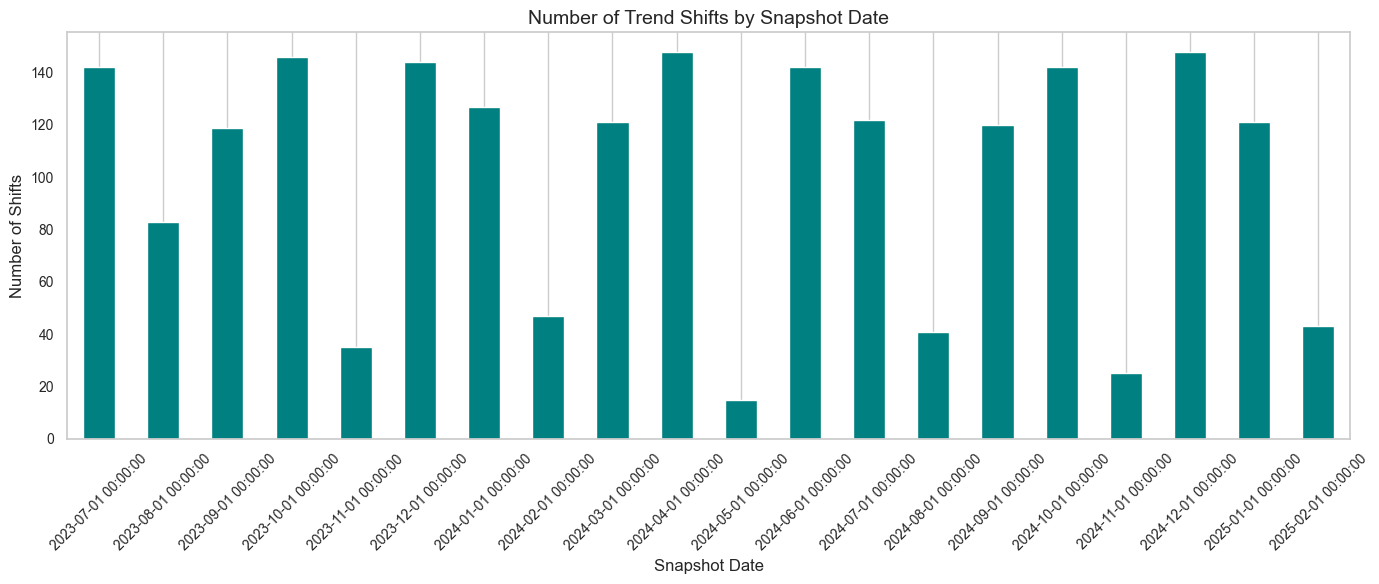

In [6]:
# Visualize trend shifts by snapshot date
shifts_by_date = trend_shifts_df[trend_shifts_df['Trend_Shift']].groupby('Snapshot_Date').size()

plt.figure(figsize=(14, 6))
shifts_by_date.plot(kind='bar', color='teal')
plt.title('Number of Trend Shifts by Snapshot Date')
plt.xlabel('Snapshot Date')
plt.ylabel('Number of Shifts')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

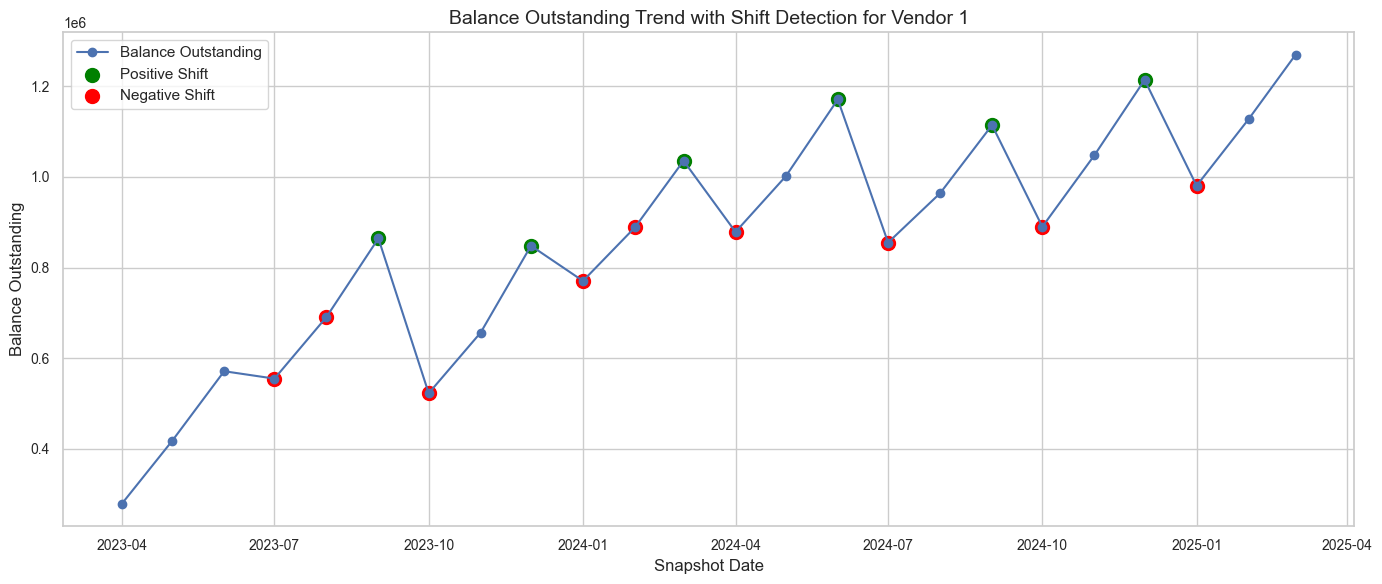

In [7]:
# Visualize an example vendor with a trend shift
if trend_shifts_df['Trend_Shift'].sum() > 0:
    # Find a vendor with trend shifts
    example_vendor_id = trend_shifts_df[trend_shifts_df['Trend_Shift']].iloc[0]['Vendor ID']
    vendor_data = trend_shifts_df[trend_shifts_df['Vendor ID'] == example_vendor_id].sort_values('Snapshot_Date')
    
    plt.figure(figsize=(14, 6))
    
    # Plot the balance outstanding
    plt.plot(vendor_data['Snapshot_Date'], vendor_data['Balance Outstanding'], marker='o', label='Balance Outstanding')
    
    # Highlight the trend shifts
    shift_points = vendor_data[vendor_data['Trend_Shift']]
    if not shift_points.empty:
        for direction in ['Positive', 'Negative']:
            direction_points = shift_points[shift_points['Trend_Shift_Direction'] == direction]
            if not direction_points.empty:
                plt.scatter(direction_points['Snapshot_Date'], direction_points['Balance Outstanding'], 
                           s=100, label=f'{direction} Shift',
                           color='green' if direction == 'Positive' else 'red')
    
    plt.title(f'Balance Outstanding Trend with Shift Detection for Vendor {example_vendor_id}')
    plt.xlabel('Snapshot Date')
    plt.ylabel('Balance Outstanding')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Seasonal patterns

In [8]:
def analyze_seasonal_patterns(df, snapshot_date_col='Snapshot_Date', vendor_id_col='Vendor ID',
                            value_col='Balance Outstanding', period=12, min_periods=24):
    """
    Analyze seasonal patterns in vendor aging data.

    Args:
        df (pandas.DataFrame): Prepared vendor aging data
        snapshot_date_col (str): Column containing snapshot date
        vendor_id_col (str): Column containing vendor identifier
        value_col (str): Column to analyze for seasonal patterns
        period (int): Expected seasonality period (e.g., 12 for annual)
        min_periods (int): Minimum number of periods required for analysis

    Returns:
        dict: Dictionary with seasonal analysis results by vendor
    """
    # Create a copy to avoid modifying the original
    result_df = df.copy()

    # Ensure date columns are datetime
    if not pd.api.types.is_datetime64_any_dtype(result_df[snapshot_date_col]):
        result_df[snapshot_date_col] = pd.to_datetime(result_df[snapshot_date_col], errors='coerce')

    # Results container
    seasonal_results = {}

    # Check if statsmodels is available
    if not statsmodels_available:
        print("Statsmodels not available, using simplified seasonal analysis")
        
        # Simplified approach without statsmodels
        for vendor_id, group in result_df.groupby(vendor_id_col):
            if len(group) >= min_periods // 2:  # Relaxed requirement
                vendor_data = group.sort_values(snapshot_date_col)
                
                # Create a month field for grouping
                vendor_data['month'] = vendor_data[snapshot_date_col].dt.month
                
                # Calculate average by month
                monthly_avg = vendor_data.groupby('month')[value_col].mean()
                
                # Calculate simple seasonal strength (max month - min month) / mean
                seasonal_strength = (monthly_avg.max() - monthly_avg.min()) / monthly_avg.mean() if monthly_avg.mean() != 0 else 0
                
                seasonal_results[vendor_id] = {
                    'has_seasonality': seasonal_strength > 0.2,  # Arbitrary threshold
                    'seasonal_strength': seasonal_strength,
                    'peak_month': monthly_avg.idxmax(),
                    'trough_month': monthly_avg.idxmin(),
                    'monthly_averages': monthly_avg.to_dict()
                }
        
        return seasonal_results
    
    # If statsmodels is available, use the full analysis
    for vendor_id, group in result_df.groupby(vendor_id_col):
        # Need enough data points for seasonal analysis
        if len(group) >= min_periods:
            vendor_data = group.sort_values(snapshot_date_col)

            # Create a time series
            ts = vendor_data.set_index(snapshot_date_col)[value_col]

            try:
                # Check if data is stationary
                adf_result = adfuller(ts.values, autolag='AIC')
                is_stationary = adf_result[1] < 0.05  # p-value < 0.05 indicates stationarity

                # Perform seasonal decomposition if we have enough data points
                decomposition = seasonal_decompose(ts, model='additive', period=period, extrapolate_trend='freq')

                # Extract components
                trend = decomposition.trend
                seasonal = decomposition.seasonal
                residual = decomposition.resid

                # Calculate strength of seasonality
                # (1 - variance of residual / variance of detrended series)
                detrended = ts - trend
                seasonal_strength = max(0, 1 - residual.var() / detrended.var())

                seasonal_results[vendor_id] = {
                    'has_seasonality': seasonal_strength > 0.3,  # Arbitrary threshold
                    'seasonal_strength': seasonal_strength,
                    'is_stationary': is_stationary,
                    'peak_month': seasonal.groupby(seasonal.index.month).mean().idxmax(),
                    'trough_month': seasonal.groupby(seasonal.index.month).mean().idxmin(),
                    'components': {
                        'trend': trend,
                        'seasonal': seasonal,
                        'residual': residual
                    }
                }

            except Exception as e:
                # Not enough data or other issues
                seasonal_results[vendor_id] = {
                    'has_seasonality': False,
                    'error': str(e)
                }

    return seasonal_results


Vendors with detected seasonality: 31
Total vendors analyzed: 150
Percentage with seasonality: 20.7%


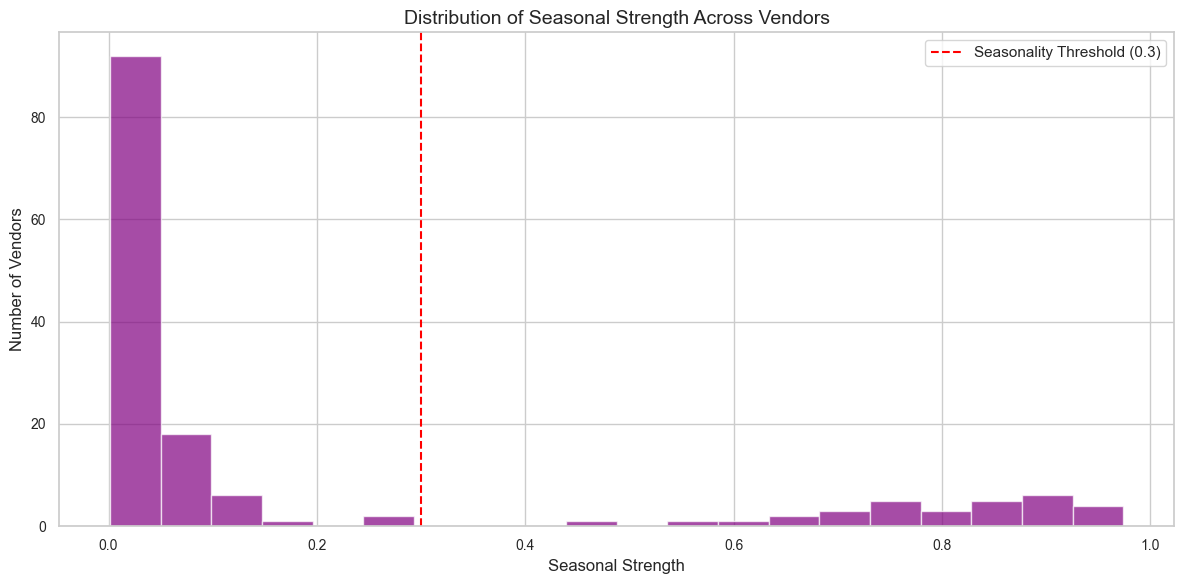

In [9]:
seasonal_results = analyze_seasonal_patterns(metrics_df, min_periods=6, period=4)  # Lowered requirements for demo

# Display information about seasonal patterns
vendors_with_seasonality = sum(1 for v_id, result in seasonal_results.items() if result.get('has_seasonality', False))
print(f"\nVendors with detected seasonality: {vendors_with_seasonality}")
print(f"Total vendors analyzed: {len(seasonal_results)}")
print(f"Percentage with seasonality: {vendors_with_seasonality / len(seasonal_results) * 100:.1f}%")

# Visualize seasonal strength distribution
seasonal_strengths = [result['seasonal_strength'] for _, result in seasonal_results.items() 
                      if 'seasonal_strength' in result and not pd.isna(result['seasonal_strength'])]

plt.figure(figsize=(12, 6))
plt.hist(seasonal_strengths, bins=20, color='purple', alpha=0.7)
plt.axvline(x=0.3, color='red', linestyle='--', label='Seasonality Threshold (0.3)')
plt.title('Distribution of Seasonal Strength Across Vendors')
plt.xlabel('Seasonal Strength')
plt.ylabel('Number of Vendors')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

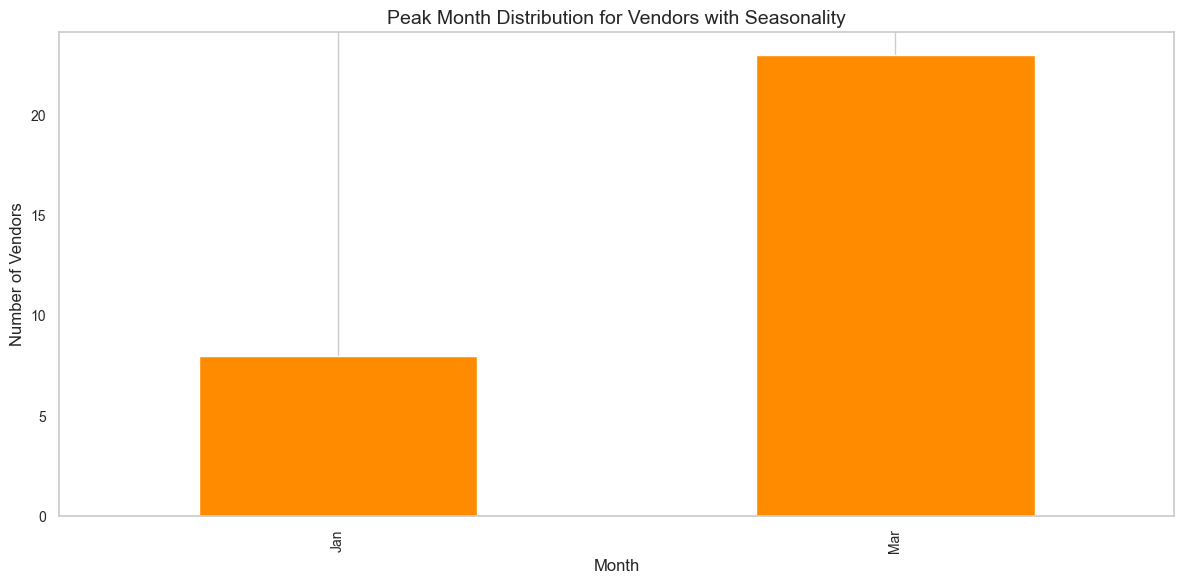

In [10]:
peak_months = [result['peak_month'] for _, result in seasonal_results.items() 
              if 'peak_month' in result and result.get('has_seasonality', False)]

if peak_months:
    plt.figure(figsize=(12, 6))
    month_counts = pd.Series(peak_months).value_counts().sort_index()
    
    # Map month numbers to month names
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    month_counts.index = [month_names[i-1] for i in month_counts.index]
    
    month_counts.plot(kind='bar', color='darkorange')
    plt.title('Peak Month Distribution for Vendors with Seasonality')
    plt.xlabel('Month')
    plt.ylabel('Number of Vendors')
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

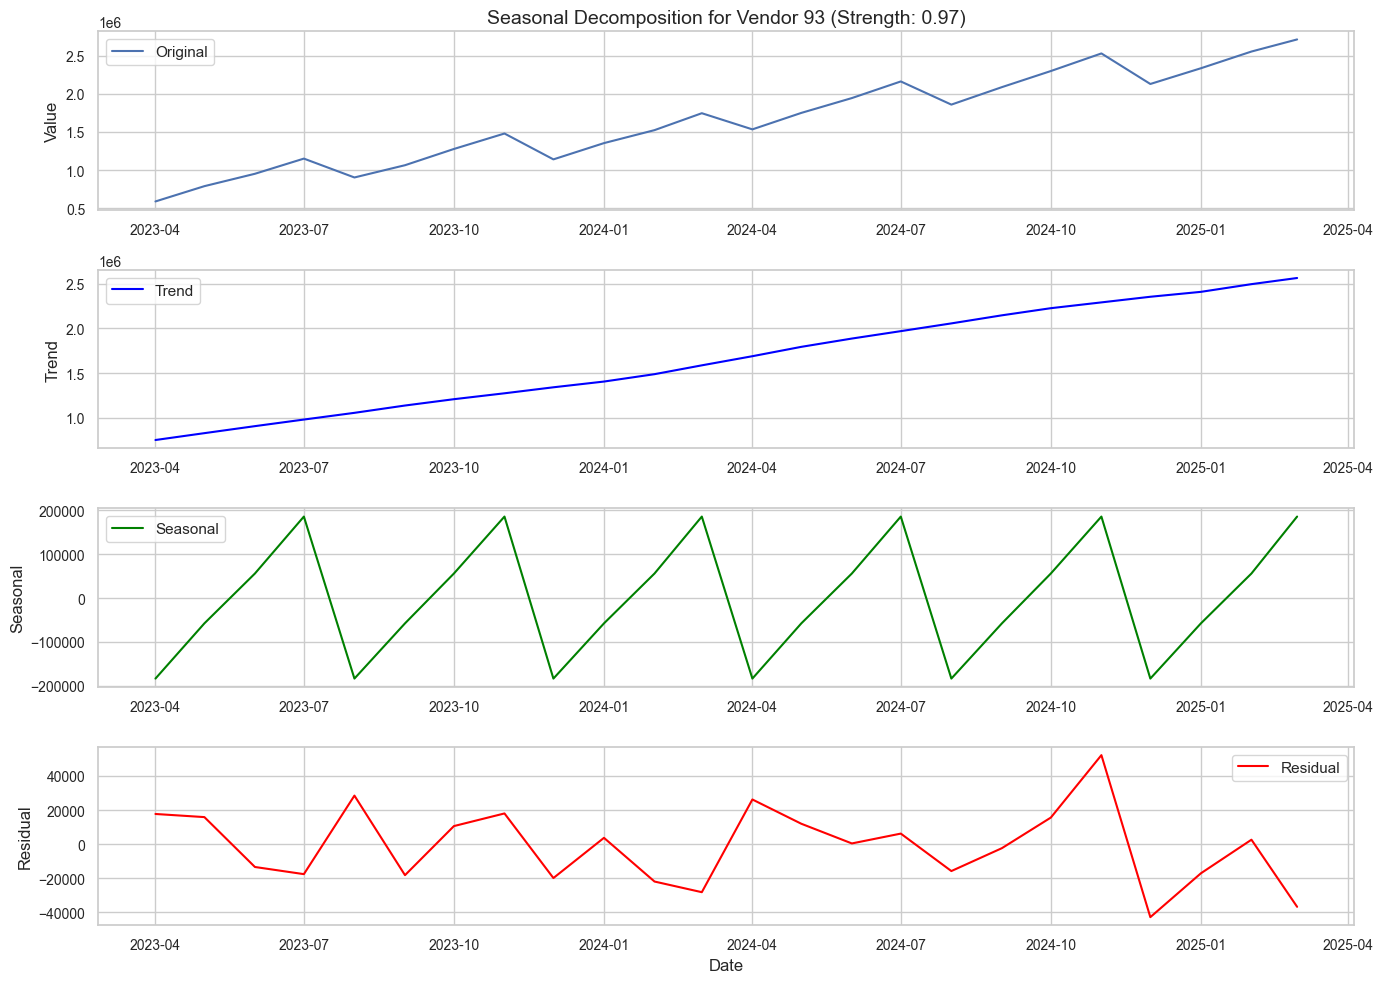

In [11]:
# Visualize decomposition for a vendor with strong seasonality
if vendors_with_seasonality > 0 and statsmodels_available:
    # Find a vendor with strong seasonality
    seasonal_vendors = [(v_id, result['seasonal_strength']) 
                        for v_id, result in seasonal_results.items() 
                        if result.get('has_seasonality', False) and 'seasonal_strength' in result]
    
    if seasonal_vendors:
        seasonal_vendors.sort(key=lambda x: x[1], reverse=True)
        top_seasonal_vendor_id = seasonal_vendors[0][0]
        vendor_result = seasonal_results[top_seasonal_vendor_id]
        
        if 'components' in vendor_result:
            plt.figure(figsize=(14, 10))
            
            # Plot original data
            plt.subplot(4, 1, 1)
            vendor_result['components']['trend'].index.to_series().map(lambda x: x.strftime('%Y-%m-%d'))
            ts_values = vendor_result['components']['trend'].index.to_series().map(lambda x: x)
            plt.plot(ts_values, vendor_result['components']['trend'] + vendor_result['components']['seasonal'] + vendor_result['components']['residual'], label='Original')
            plt.title(f'Seasonal Decomposition for Vendor {top_seasonal_vendor_id} (Strength: {vendor_result["seasonal_strength"]:.2f})')
            plt.ylabel('Value')
            plt.legend()
            plt.grid(True)
            
            # Plot trend
            plt.subplot(4, 1, 2)
            plt.plot(ts_values, vendor_result['components']['trend'], label='Trend', color='blue')
            plt.ylabel('Trend')
            plt.legend()
            plt.grid(True)
            
            # Plot seasonal
            plt.subplot(4, 1, 3)
            plt.plot(ts_values, vendor_result['components']['seasonal'], label='Seasonal', color='green')
            plt.ylabel('Seasonal')
            plt.legend()
            plt.grid(True)
            
            # Plot residual
            plt.subplot(4, 1, 4)
            plt.plot(ts_values, vendor_result['components']['residual'], label='Residual', color='red')
            plt.ylabel('Residual')
            plt.xlabel('Date')
            plt.legend()
            plt.grid(True)
            
            plt.tight_layout()
            plt.show()

# Pattern anomalies

In [12]:
def detect_pattern_anomalies(df, snapshot_date_col='Snapshot_Date', vendor_id_col='Vendor ID',
                           value_col='Balance Outstanding', window=3, threshold=2.0):
    """
    Detect anomalies in time series patterns for each vendor.

    Args:
        df (pandas.DataFrame): Prepared vendor aging data
        snapshot_date_col (str): Column containing snapshot date
        vendor_id_col (str): Column containing vendor identifier
        value_col (str): Column to analyze for pattern anomalies
        window (int): Window size for pattern detection
        threshold (float): Z-score threshold for flagging anomalies

    Returns:
        pandas.DataFrame: DataFrame with pattern anomaly flags
    """
    # Create a copy to avoid modifying the original
    result_df = df.copy()

    # Initialize anomaly columns
    result_df['Pattern_Anomaly'] = False
    result_df['Pattern_Zscore'] = np.nan
    result_df['Pattern_Change'] = np.nan

    # Process each vendor separately
    for vendor_id, vendor_df in result_df.groupby(vendor_id_col):
        # Need enough data points for pattern analysis
        if len(vendor_df) < window + 1:
            continue

        # Sort by snapshot date
        vendor_data = vendor_df.sort_values(snapshot_date_col)

        # Calculate rolling statistics
        values = vendor_data[value_col].values

        # Calculate sequential changes
        changes = np.diff(values)

        # Calculate rolling pattern changes if we have enough data
        if len(changes) >= window:
            pattern_changes = []

            for i in range(len(changes) - window + 1):
                window_pattern = changes[i:i+window]

                # Calculate pattern change metric
                # (mean absolute change within the window)
                pattern_change = np.mean(np.abs(window_pattern))
                pattern_changes.append(pattern_change)

            # Calculate z-scores of pattern changes
            pattern_mean = np.mean(pattern_changes)
            pattern_std = np.std(pattern_changes)

            if pattern_std > 0:  # Avoid division by zero
                z_scores = np.abs((pattern_changes - pattern_mean) / pattern_std)

                # Flag anomalies
                anomaly_flags = z_scores > threshold

                # Update the main dataframe
                # We need to align the indices correctly
                start_idx = window  # Skip first "window" snapshots since we need diff and rolling window
                for i, anomaly in enumerate(anomaly_flags):
                    idx = vendor_data.index[start_idx + i]
                    result_df.loc[idx, 'Pattern_Anomaly'] = anomaly
                    result_df.loc[idx, 'Pattern_Zscore'] = z_scores[i]
                    result_df.loc[idx, 'Pattern_Change'] = pattern_changes[i]

    return result_df

In [16]:
threshold=2.0

In [17]:
pattern_anomalies_df = detect_pattern_anomalies(metrics_df,threshold=threshold)

# Display information about pattern anomalies
print("\nPattern anomaly detection results:")
print(f"Number of detected pattern anomalies: {pattern_anomalies_df['Pattern_Anomaly'].sum()}")

# Count pattern anomalies by snapshot date
anomaly_count_by_date = pattern_anomalies_df.groupby('Snapshot_Date')['Pattern_Anomaly'].sum()




Pattern anomaly detection results:
Number of detected pattern anomalies: 95


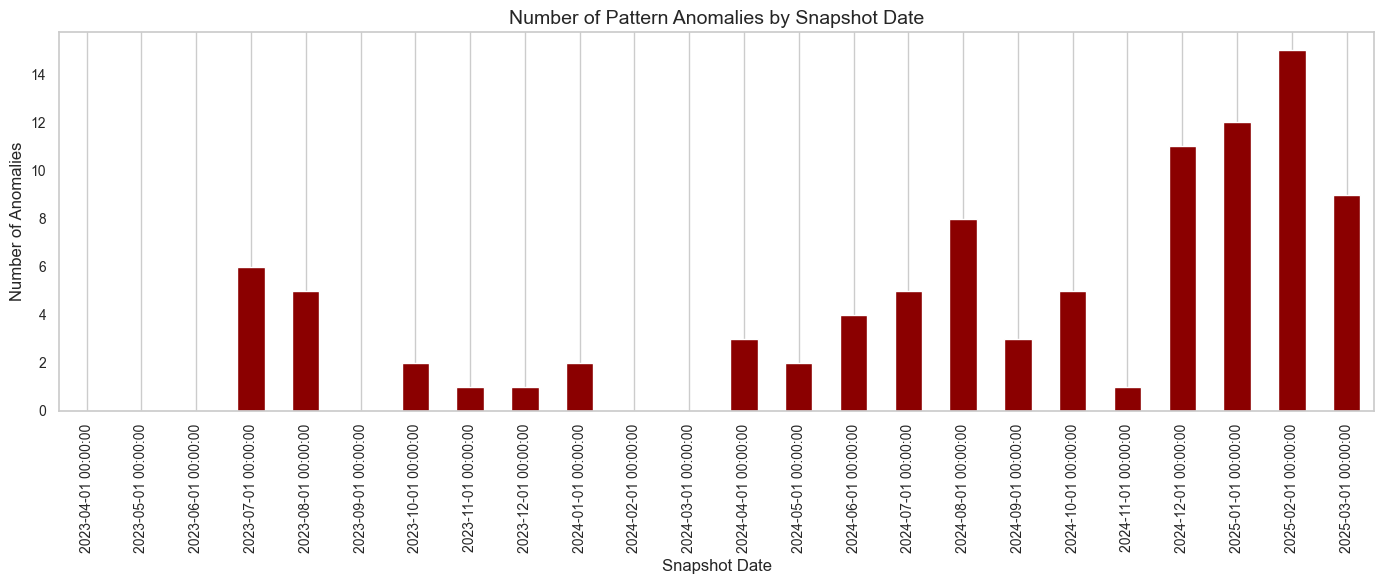

In [18]:
plt.figure(figsize=(14, 6))
anomaly_count_by_date.plot(kind='bar', color='darkred')
plt.title('Number of Pattern Anomalies by Snapshot Date')
plt.xlabel('Snapshot Date')
plt.ylabel('Number of Anomalies')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

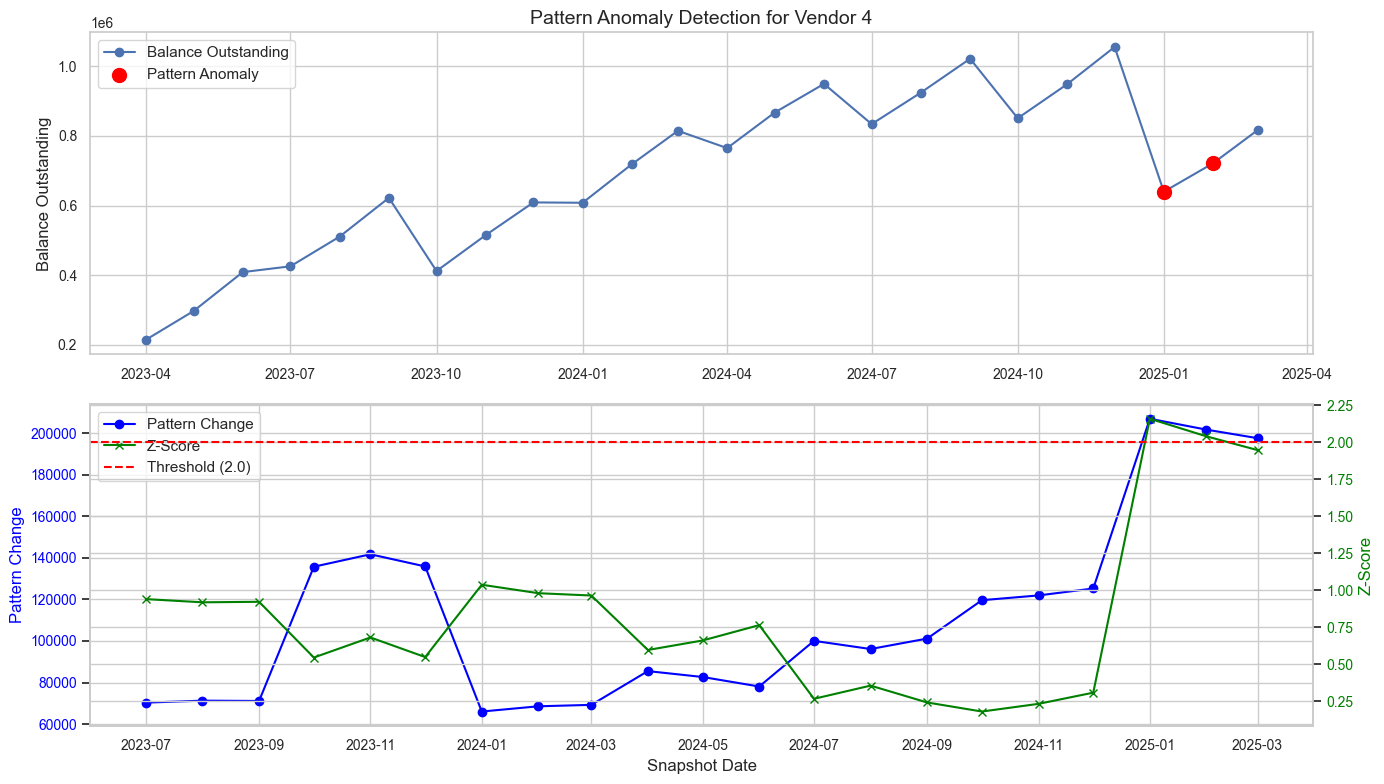

In [19]:
# Visualize an example vendor with pattern anomalies
if pattern_anomalies_df['Pattern_Anomaly'].sum() > 0:
    # Find a vendor with pattern anomalies
    example_vendor_id = pattern_anomalies_df[pattern_anomalies_df['Pattern_Anomaly']].iloc[0]['Vendor ID']
    vendor_data = pattern_anomalies_df[pattern_anomalies_df['Vendor ID'] == example_vendor_id].sort_values('Snapshot_Date')
    
    plt.figure(figsize=(14, 8))
    
    # Plot the main metric
    plt.subplot(2, 1, 1)
    plt.plot(vendor_data['Snapshot_Date'], vendor_data['Balance Outstanding'], marker='o', label='Balance Outstanding')
    
    # Highlight pattern anomalies
    anomaly_points = vendor_data[vendor_data['Pattern_Anomaly']]
    if not anomaly_points.empty:
        plt.scatter(anomaly_points['Snapshot_Date'], anomaly_points['Balance Outstanding'], 
                   color='red', s=100, label='Pattern Anomaly', zorder=5)
    
    plt.title(f'Pattern Anomaly Detection for Vendor {example_vendor_id}')
    plt.ylabel('Balance Outstanding')
    plt.legend()
    plt.grid(True)
    
    # Plot the pattern changes and z-scores
    plt.subplot(2, 1, 2)
    
    # Plot pattern change
    ax1 = plt.gca()
    ax1.set_xlabel('Snapshot Date')
    ax1.set_ylabel('Pattern Change', color='blue')
    line1 = ax1.plot(vendor_data['Snapshot_Date'], vendor_data['Pattern_Change'], 
                    marker='o', color='blue', label='Pattern Change')
    ax1.tick_params(axis='y', labelcolor='blue')
    
    # Plot z-score on secondary axis
    ax2 = ax1.twinx()
    ax2.set_ylabel('Z-Score', color='green')
    line2 = ax2.plot(vendor_data['Snapshot_Date'], vendor_data['Pattern_Zscore'], 
                    marker='x', color='green', label='Z-Score')
    ax2.tick_params(axis='y', labelcolor='green')
    
    # Add threshold line
    ax2.axhline(y=threshold, color='red', linestyle='--', label=f'Threshold ({threshold})')
    
    # Combine legends
    lines = line1 + line2 + [plt.Line2D([0], [0], color='red', linestyle='--')]
    labels = ['Pattern Change', 'Z-Score', f'Threshold ({threshold})']
    ax1.legend(lines, labels, loc='upper left')
    
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [20]:
print("\n" + "="*80)
print("SUMMARY OF PATTERN DETECTION FUNCTIONS")
print("="*80)
print("\n1. detect_trend_shifts:")
print("   - Identifies points where a vendor's trend direction changes significantly")
print("   - Detects both sign changes (positive to negative or vice versa) and magnitude changes")
print("   - Helps identify when a vendor's behavior pattern fundamentally changes")
print("   - Critical for understanding when interventions may be needed")

print("\n2. analyze_seasonal_patterns:")
print("   - Decomposes time series into trend, seasonal, and residual components")
print("   - Identifies vendors with regular seasonal patterns in their aging metrics")
print("   - Calculates seasonal strength and identifies peak/trough months")
print("   - Important for anticipating and planning for cyclical payment behavior")

print("\n3. detect_pattern_anomalies:")
print("   - Looks for unusual patterns in the way metrics change over time")
print("   - Uses rolling windows to calculate pattern metrics and their z-scores")
print("   - Detects when the pattern of changes is abnormal, not just the values themselves")
print("   - Valuable for finding subtle anomalies that might not be visible in raw values")

print("\nThese three functions together provide a comprehensive view of the underlying")
print("patterns in vendor aging data. They help identify not just what is happening,")
print("but the patterns of how it's happening, enabling more sophisticated forecasting")
print("and anomaly detection. This pattern-based approach is particularly valuable for")
print("detecting early warning signs before they become severe issues.")


SUMMARY OF PATTERN DETECTION FUNCTIONS

1. detect_trend_shifts:
   - Identifies points where a vendor's trend direction changes significantly
   - Detects both sign changes (positive to negative or vice versa) and magnitude changes
   - Helps identify when a vendor's behavior pattern fundamentally changes
   - Critical for understanding when interventions may be needed

2. analyze_seasonal_patterns:
   - Decomposes time series into trend, seasonal, and residual components
   - Identifies vendors with regular seasonal patterns in their aging metrics
   - Calculates seasonal strength and identifies peak/trough months
   - Important for anticipating and planning for cyclical payment behavior

3. detect_pattern_anomalies:
   - Looks for unusual patterns in the way metrics change over time
   - Uses rolling windows to calculate pattern metrics and their z-scores
   - Detects when the pattern of changes is abnormal, not just the values themselves
   - Valuable for finding subtle anomalies t